In [7]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
sns.set()

In [8]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)

## The Titanic Dataset

1. Survived: 0 (no) or 1(yes)
2. Pclass: ticket class, 1 (upper), 2 (middle) or 3 (lower)
3. Sex: 0 (male) or 1 (female)
4. Age: float, ranging from 0.4 to 80, contains NaN

In [14]:
titanic_training = pd.read_csv('train.csv')
titanic_training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
titanic_training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [16]:
def get_conditional_probability(df, events, conditions):
    """calculate P(events|conditions), events and conditions are represent by dictionaries"""
    dfc = df.copy()
    for key, value in conditions.items():
        dfc = dfc.loc[dfc[key] == value]
    total = len(dfc)
    if total == 0:
        return 1
    for key, value in events.items():
        dfc = dfc.loc[dfc[key] == value]
    return len(dfc) / total

## Question 1: What if Jack bought a first class ticket?

#### Statement 1: buying 1st class ticket increases one's survival rate by 39%.

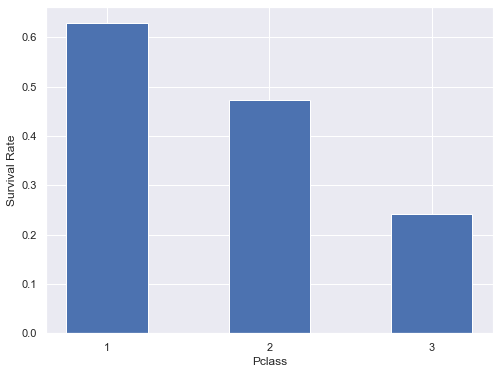

In [20]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def plot_survival_rate_per_pclass(df):
    rates = []
    for pclass in [1, 2, 3]:
        survival_rate = get_conditional_probability(df, {'Survived': 1}, {'Pclass': pclass})
        rates.append(survival_rate)

    fig, ax = plt.subplots()
    rects = ax.bar([1, 2, 3], rates, 0.5)
    ax.set_xlabel('Pclass')
    ax.set_xticks([1, 2, 3])
    ax.set_ylabel('Survival Rate')
    autolabel(rects)
    plt.show()

plot_survival_rate_per_pclass(titanic_training)

#### Statement 2: buying 1st class ticket increases a man's survival rate by 23%, and increases a woman's survival rate by 47%.

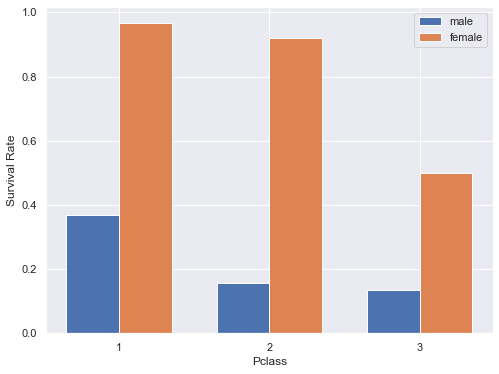

In [21]:
def plot_survival_rate_per_pclass_sex(df):
    rates = {'male': [], 'female': []}
    for pclass in [1, 2, 3]:
        for sex in ['male', 'female']:
            conditions = {'Pclass': pclass, 'Sex': sex}
            survival_rate_by_sex = get_conditional_probability(df, {'Survived': 1}, conditions)
            rates[sex].append(survival_rate_by_sex)

    fig, ax = plt.subplots()
    width = 0.35
    x = np.array([1, 2, 3])
    rects1 = ax.bar(x - width / 2, rates['male'], width, label='male')
    rects2 = ax.bar(x + width / 2, rates['female'], width, label='female')
    ax.set_ylabel('Survival Rate')
    ax.set_xlabel('Pclass')
    ax.set_xticks([1, 2, 3])
    ax.legend()

    autolabel(rects1)
    autolabel(rects2)
    plt.show()

plot_survival_rate_per_pclass_sex(titanic_training)

### Intervetions

#### Story 1: sex as a confounder 

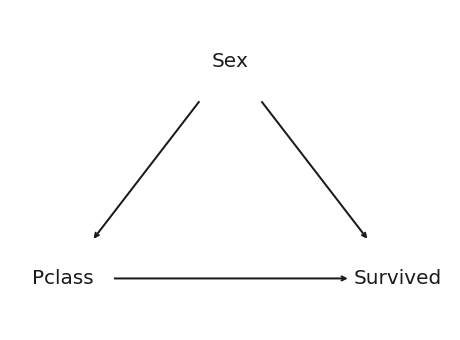

In [8]:
Image(filename='dag1.png')

Assuming the above dependency graph, statement 1 needs adjustment:

$\text{P}(Survived|\text{do}(Pclass)) = \text{P}(Survived|Pclass,\ Sex) \text{P}(Sex) + \text{P}(Survived|Pclass,\ Sex) \text{P}(Sex)$

We calculate Average Causal Effect (ACE)

$\text{ACE} = \text{P}(Survived=1|\text{do}(Pclass=1)) - \text{P}(Survived=1|\text{do}(Pclass=3))$

In [43]:
def survival_rate_do_pclass(df, pclass):
    # calculate P(Survived=1|do(Pclass=pclass)), using adjustment w.r.t Sex
    result = 0
    for sex in ['male', 'female']:
        p_sex = get_conditional_probability(df, {'Sex': sex}, {})
        survival_rate = get_conditional_probability(df, {'Survived': 1}, {'Pclass': pclass, 'Sex': sex})
        result += survival_rate * p_sex
    return result

def ace_do_pclass(df, original_pclass, hypothetical_pclass):
    p_original = survival_rate_do_pclass(df, original_pclass)
    p_hypothetical = survival_rate_do_pclass(df, hypothetical_pclass)
    print('P(Survived=1|do(Pclass={})) = {:.3f}'.format(original_pclass, p_original))
    print('P(Survived=1|do(Pclass={})) = {:.3f}'.format(hypothetical_pclass, p_hypothetical))
    print('ACE = {:.3f}'.format(p_hypothetical - p_original))

ace_do_pclass(titanic_training, 3, 1)

P(Survived=1|do(Pclass=3)) = 0.264
P(Survived=1|do(Pclass=1)) = 0.580
ACE = 0.316


**Same result using inverse probability weighting.**

In [42]:
def add_weights(df):
    df['weight'] = 0
    for pclass in [1, 2, 3]:
        for sex in ['male', 'female']:
            weight = 1 / get_conditional_probability(df, {'Pclass': pclass}, {'Sex': sex})
            df.loc[(df['Pclass'] == pclass) & (df['Sex'] == sex), 'weight'] = weight

def survival_rate_do_pclass_ipw(df, pclass):
    print('calculated with inverse probability weighting')
    add_weights(df)
    n = len(df)
    dfc = df[(df['Survived'] == 1) & (df['Pclass'] == pclass)]
    result = dfc['weight'].sum() / n
    return result

def ace_do_pclass_ipw(df, original_pclass, hypothetical_pclass):
    p_original = survival_rate_do_pclass_ipw(df, original_pclass)
    p_hypothetical = survival_rate_do_pclass_ipw(df, hypothetical_pclass)
    print('P(Survived=1|do(Pclass={})) = {:.3f}'.format(original_pclass, p_original))
    print('P(Survived=1|do(Pclass={})) = {:.3f}'.format(hypothetical_pclass, p_hypothetical))
    print('ACE = {:.3f}'.format(p_hypothetical - p_original))

ace_do_pclass_ipw(titanic_training, 3, 1)

calculated with inverse probability weighting
calculated with inverse probability weighting
P(Survived=1|do(Pclass=3)) = 0.264
P(Survived=1|do(Pclass=1)) = 0.580
ACE = 0.316


Sex-specific effect

$\text{P}(Survived|\text{do}(Pclass),\ Sex) = \text{P}(Survived|Pclass,\ Sex)$

Argument 2 does not need adjustment.

From causal inference's point of view, if we assume sex as the only confounder, upgrading from 3rd class to 1st class increases one's survival rate by **32%**, a male's survival rate is increased by **23%** and a female's survival rate is increased by **47%**.

#### Story 2: age also plays a role.

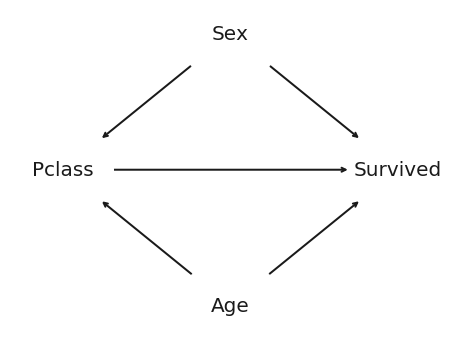

In [31]:
Image(filename='dag2.png')

Age feature has 89 different values, better discretize by percentile.

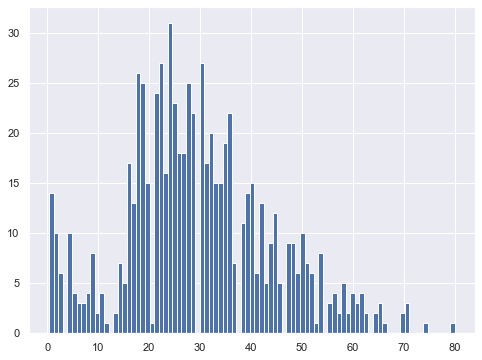

In [36]:
titanic_training['Age'].hist(bins=len(titanic_training['Age'].unique()))

In [47]:
def discretize(df, column_name, n_bins):
    dfc = df.copy()
    nan_mask = pd.isna(dfc[column_name])
    # reserve one bin for NaN
    dfc[column_name] = pd.qcut(dfc[column_name], n_bins - 1, labels=False, duplicates='drop')
    dfc.loc[nan_mask, column_name] = -1
    return dfc


def survival_rate_do_pclass_v2(df, pclass):
    # calculate P(Survived=1|do(Pclass=pclass)), using adjustment w.r.t Sex and Age
    result = 0
    for sex in ['male', 'female']:
        for age in df[df['Sex'] == sex]['Age'].unique():
            p_sex_age = get_conditional_probability(df, {'Sex': sex, 'Age': age}, {})
            survival_rate = get_conditional_probability(df, {'Survived': 1},
                                                        {'Pclass': pclass, 'Sex': sex, 'Age': age})
            result += survival_rate * p_sex_age
    return result

def ace_do_pclass_v2(n_age_bins):
    df = discretize(titanic_training, 'Age', n_age_bins)
    p1 = survival_rate_do_pclass_v2(df, 1)
    p3 = survival_rate_do_pclass_v2(df, 3)
    print('P(Survived=1|do(Pclass=1)) = {:.3f}'.format(p1))
    print('P(Survived=1|do(Pclass=3)) = {:.3f}'.format(p3))
    print('ACE = {:.3f}'.format(p1 - p3))

interact(ace_do_pclass_v2,
         n_age_bins=widgets.IntSlider(min=2, max=89, step=1, value=10, continuous_update=False))

interactive(children=(IntSlider(value=10, continuous_update=False, description='n_age_bins', max=89, min=2), O…

<function __main__.ace_do_pclass_v2(n_age_bins)>

If we assume the new DAG, taking age into account and discretize it into 10 bins, upgrading from 3rd class to 1st class increases one's survival rate by **34%**.

#### Cost?

In [38]:
titanic_training.groupby(['Pclass'])['Fare'].agg('mean')

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

## Question 2: what if Jack were female?

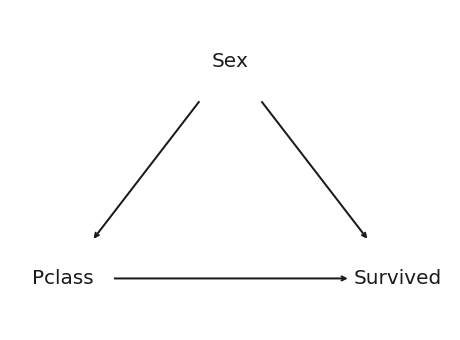

In [39]:
Image(filename='dag1.png')

$\text{P}(Survived=1|Sex=female,\ Pclass=3) - \text{P}(Survived=1|Sex=male,\ Pclass=3)$

In [67]:
def direct_effect_of_sex(df):
    p_female = get_conditional_probability(df, {'Survived': 1}, {'Sex': 'female', 'Pclass': 3})
    p_male = get_conditional_probability(df, {'Survived': 1}, {'Sex': 'male', 'Pclass': 3})
    print('P(Survived|female, 3rd class) = {:.2f}'.format(p_female))
    print('P(Survived|male, 3rd class) = {:.2f}'.format(p_male))
    print('Direct effect of sex = {:.2f}'.format(p_female - p_male))

direct_effect_of_sex(titanic_training)

P(Survived|female, 3rd class) = 0.50
P(Survived|male, 3rd class) = 0.14
Direct effect of sex = 0.36


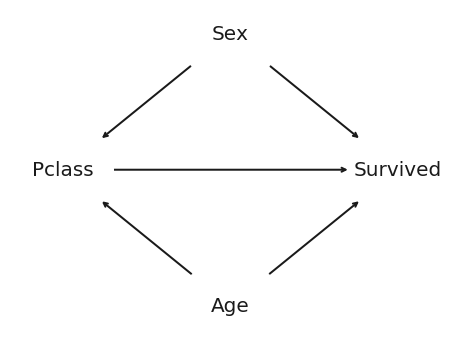

In [50]:
Image(filename='dag2.png')

Controlled Direct Effect (CDE)

$CDE = \text{P}(Survived=1|\text{do}(Sex=female),\ \text{do}(Pclass=3)) - \text{P}(Survived=1|\text{do}(Sex=male),\ \text{do}(Pclass=3))$

where

$$\text{P}(Survived=1|\text{do}(Sex=female),\ \text{do}(Pclass=3)) = \sum_a \text{P}(Survived=1|Sex=female,\ Pclass=3,\ Age=a)\text{P}(Age=a)$$

In [52]:
def survival_rate_controlling_age(df, sex, pclass):
    # calculate P(Survived=1|do(Sex=sex), do(Pclass=pclass)), using adjustment w.r.t Age
    result = 0
    for age in df['Age'].unique():
        p_age = get_conditional_probability(df, {'Age': age}, {})
        conditions = {'Sex': sex, 'Pclass': pclass, 'Age': age}
        survival_rate = get_conditional_probability(df, {'Survived': 1}, conditions)
        result += survival_rate * p_age
    return result

def calculate_cde_of_sex(pclass, n_age_bins):
    df = discretize(titanic_training, 'Age', n_age_bins)
    p_female = survival_rate_controlling_age(df, 'female', pclass)
    p_male = survival_rate_controlling_age(df, 'male', pclass)
    print('P(Survived=1|do(Sex=female), do(Pclass={})) = {:.3f}'.format(pclass, p_female))
    print('P(Survived=1|do(Sex=male), do(Pclass={})) = {:.3f}'.format(pclass, p_male))
    print('CDE = {:.3f}'.format(p_female - p_male))

interact(calculate_cde_of_sex,
         pclass=widgets.Dropdown(options=[1, 2, 3], value=3, description='Pclass:', disabled=False),
         n_age_bins=widgets.IntSlider(min=2, max=89, step=1, value=10, continuous_update=False))

interactive(children=(Dropdown(description='Pclass:', index=2, options=(1, 2, 3), value=3), IntSlider(value=10…

<function __main__.calculate_cde_of_sex(pclass, n_age_bins)>

## Regression Coefficients

In [60]:
def print_formula(feature_names, target_name, model):
    lhs = target_name
    rhs = '{:.2f} '.format(model.intercept_)
    for name, coef in zip(feature_names, model.coef_):
        sign = '+' if coef > 0 else '-'
        rhs += '{} {:.2f}*{} '.format(sign, abs(coef), name)
    print(lhs + ' = ' + rhs)

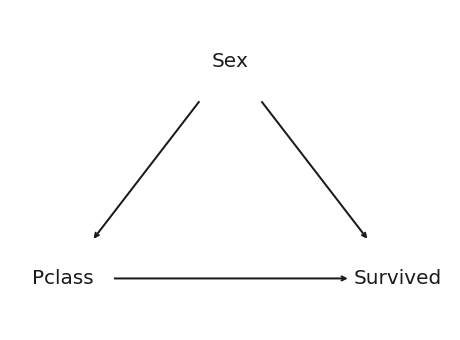

In [68]:
Image(filename='dag1.png')

In [90]:
def total_effect_of_sex():
    df = titanic_training.copy()
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    lm = LinearRegression(fit_intercept=False)
    feature_columns = ['Sex']
    lm.fit(df[feature_columns], df['Survived'])
    print_formula(feature_columns, 'Survived', lm)

total_effect_of_sex()

Survived = 0.00 + 0.74*Sex 


In [93]:
def direct_effect_of_sex():
    df = titanic_training.copy()
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    lm = LinearRegression(fit_intercept=False)
    feature_columns = ['Sex', 'Pclass']
    lm.fit(df[feature_columns], df['Survived'])
    print_formula(feature_columns, 'Survived', lm)

direct_effect_of_sex()

Survived = 0.00 + 0.65*Sex + 0.04*Pclass 


Direct effect of sex: **65%**, total effect of sex: **74%**.

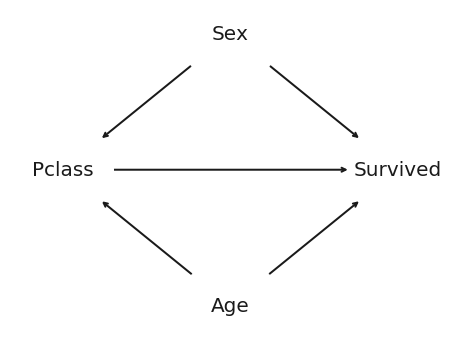

In [69]:
Image(filename='dag2.png')

In [94]:
def direct_effect_of_sex_v2():
    df = titanic_training.copy()
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    lm = LinearRegression()
    feature_columns = ['Sex', 'Pclass', 'Age']
    lm.fit(df[feature_columns], df['Survived'])
    print_formula(feature_columns, 'Survived', lm)

total_effect_of_sex_v2()

Survived = 0.78 + 0.50*Sex - 0.19*Pclass - 0.01*Age 


Direct effect of sex: **50%**.

In [19]:
# import networkx as nx
# def plot_dag():
#     from_nodes = ['Sex', 'Sex', 'Pclass', 'Age', 'Age']
#     to_nodes = ['Pclass', 'Survived', 'Survived', 'Pclass', 'Survived']
#     df = pd.DataFrame({'from': from_nodes, 'to': to_nodes})
#     # Define Node Positions
#     pos = {'Sex':(4, 11),
#            'Pclass':(1, 6),
#            'Survived': (7, 6),
#            'Age': (4, 1)}
#     labels = {x: x for x in from_nodes + to_nodes}
#     # Build your graph. Note that we use the DiGraph function to create the graph! This adds arrows
#     dag = nx.from_pandas_edgelist(df, 'from', 'to', create_using=nx.DiGraph())
#     nodes = nx.draw_networkx_nodes(dag, pos, alpha=1, node_color='white', node_shape='o', node_size=1e4)
#     nx.draw_networkx_labels(dag, pos, labels, font_size=20)
#     edges = nx.draw_networkx_edges(dag, pos, width=2, arrowsizes=10, arrowstyle='->', node_size=1e4)

#     plt.xlim(0,8)
#     plt.ylim(0,12)
#     plt.axis('off')
#     plt.show()

# plot_dag()